In [1]:
%matplotlib inline

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import time
from torchvision import utils, datasets, transforms, models


## Setup of the datasets

In [2]:
import crypten
import torch
import torchvision
from crypten import mpc

crypten.init()
torch.set_num_threads(1)

In [ ]:
import torch
import torch.nn as nn
import crypten


# 对比测试
def test_gradient_consistency():
    # 输入设置
    x = torch.randn(2, 3, 16, 16, requires_grad=True)
    target = torch.randn(2, 64, 32, 32)
    
    # 原生实现
    conv_native = nn.ConvTranspose2d(3, 64, 4, 2, 1)
    loss_native = ((conv_native(x) - target)**2).mean()
    loss_native.backward()
    grad_native = x.grad.clone()
    
    # 自定义实现
    x.grad = None  # 清空梯度
    conv_custom = crypten.nn.ConvTranspose2d(3, 64, 4, 2, 1)
    conv_custom.encrypt()
    
    # 将输入和目标转换为加密张量
    x_enc = crypten.cryptensor(x, requires_grad=True)
    target_enc = crypten.cryptensor(target)
    
    # 前向传播
    output_custom = conv_custom(x_enc)
    loss_custom = (output_custom - target_enc).pow(2).mean()
    
    # 反向传播
    loss_custom.backward()
    
    # 获取加密输入的梯度
    grad_custom_enc = x_enc.grad
    grad_custom = grad_custom_enc.get_plain_text()  # 解密梯度
    
    # 误差分析
    diff = (grad_native - grad_custom).abs().max()
    print(f"最大梯度差异: {diff.item()}")
    
    # PyTorch 模型权重
    weight_pytorch = conv_native.weight.detach()

    # Crypten 模型权重
    weight_crypten = conv_custom.weight.get_plain_text()

    # 对比差异
    diff_weight = (weight_pytorch - weight_crypten).abs().max()
    print(f"初始权重差异: {diff_weight.item()}")

    # PyTorch 优化器
    optimizer_pytorch = torch.optim.SGD(conv_native.parameters(), lr=0.0002)

    # Crypten 优化器
    optimizer_crypten = crypten.optim.SGD(conv_native.parameters(), lr=0.0002)

    # 对比参数更新
    for param_pytorch, param_crypten in zip(conv_native.parameters(), conv_native.parameters()):
        diff_param = (param_pytorch - param_crypten).abs().max()
        print(f"参数差异: {diff_param.item()}")

    x_enc = crypten.cryptensor(x)
    diff_data = (x - x_enc.get_plain_text()).abs().max()
    print(f"数据加密差异: {diff_data.item()}")

    criterionp = torch.nn.BCELoss()
    criterionc = crypten.nn.BCELoss()
    loss_pytorch = criterionp(conv_native(x).sigmoid(), target)
    loss_crypten = criterionc(output_custom.sigmoid(), crypten.cryptensor(target))
    print(f"PyTorch Loss: {loss_pytorch.item()}")
    print(f"Crypten Loss: {loss_crypten.get_plain_text().item()}")

test_gradient_consistency()



最大梯度差异: 3.5070250305579975e-05
初始权重差异: 0.06216694414615631
参数差异: 0.0
参数差异: 0.0
数据加密差异: 1.5228986740112305e-05
PyTorch Loss: 0.6937922239303589
Crypten Loss: 0.7220306396484375


In [10]:
from torch.utils.data import DataLoader

nc = 1  # 训练图像的通道数，彩色图像的话就是 3
nz = 100  # 输入是100 维的随机噪声 z，看作是 100 个 channel，每个特征图宽高是 1*1
ngf = 64  # 生成器中特征图的大小，
ndf = 64  # 判别器中特征图的大小
workers = 10  # 数据加载时的进程数
batch_size = 64  # 生成器输入的大小

train_data = torchvision.datasets.MNIST(root='../data', 
                                           train=True, 
                                           transform=torchvision.transforms.ToTensor(),
                                           download=True)
num_samples = len(train_data)
print(f"Number of samples in the training dataset: {num_samples}")

# 数据加载器，训练过程中不断产生数据
dataloader = DataLoader(dataset=train_data,
                        batch_size=batch_size,
                        shuffle=True,
                        num_workers=workers)

Number of samples in the training dataset: 60000


In [4]:
test_data = torchvision.datasets.MNIST(root='../data', 
                                           train=False, 
                                           transform=torchvision.transforms.ToTensor(),
                                           download=True)
num_samples = len(test_data)
print(f"Number of samples in the test dataset: {num_samples}")

Number of samples in the test dataset: 10000


### celeba

In [5]:
# dataroot = "../data/celeba/Img"  # 数据集所在的路径
# workers = 10  # 数据加载时的进程数
# batch_size = 64  # 生成器输入的大小

# image_size = 64  # 训练图像的大小
# nc = 3  # 训练图像的通道数，CelebA是彩色图像
# nz = 100  # 输入是100维的随机噪声 z
# ngf = 64  # 生成器中特征图的大小
# ndf = 64  # 判别器中特征图的大小

# train_data = torchvision.datasets.ImageFolder(root=dataroot,
#                            transform=transforms.Compose([
#                                transforms.Resize(image_size),
#                                transforms.CenterCrop(image_size),
#                                transforms.ToTensor(),
#                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
#                            ]))
# # Create the dataloader
# dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
#                                          shuffle=True, num_workers=workers)

### Cifar-10

In [6]:
# dataroot = "../data/CIFAR10"  # 数据集所在的路径
# workers = 10  # 数据加载时的进程数
# batch_size = 64  # 生成器输入的大小

# image_size = 64  # 训练图像的大小
# nc = 3  # 训练图像的通道数，CelebA是彩色图像
# nz = 100  # 输入是100维的随机噪声 z
# ngf = 64  # 生成器中特征图的大小
# ndf = 64  # 判别器中特征图的大小
# num_epochs = 5  # 训练的轮次
# lr = 0.0005  # 学习率大小
# beta1 = 0.5  # Adam 优化器的参数
# ngpu = 1  # 可用 GPU 的个数，0 代表使用 CPU

# # 训练集加载并进行归一化等操作
# train_data = datasets.CIFAR10(root=dataroot, download=True,
#                            transform=transforms.Compose([
#                                transforms.Resize(image_size),
#                                transforms.ToTensor(),
#                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
#                            ]))

# # 数据加载器，训练过程中不断产生数据
# dataloader = torch.utils.data.DataLoader(dataset=train_data,
#                         batch_size=batch_size,
#                         shuffle=True,
#                         num_workers=workers)

In [13]:
# inputs = next(iter(dataloader))[0]
# plt.figure(figsize=(10, 10))
# plt.title("Training Images")
# plt.axis('off')
# inputs = utils.make_grid(inputs[:100] * 0.5 + 0.5, nrow=10)
# plt.imshow(inputs.permute(1, 2, 0))


In [8]:
def take_samples(digits, n_samples=60000):
    """Returns images and labels based on sample size"""
    images, labels = [], []

    for i, digit in enumerate(digits):
        if i == n_samples:
            break
        image, label = digit
        images.append(image)
        label_one_hot = torch.nn.functional.one_hot(torch.tensor(label), 10)
        labels.append(label_one_hot)

    images = torch.cat(images)
    labels = torch.stack(labels)
    return images, labels

In [9]:
images, labels = take_samples(train_data, n_samples=1000)

In [10]:
images.shape

torch.Size([1000, 28, 28])

In [11]:
count = images.size(0)
count

1000

### Save Alice and Bob's Train_data

In [12]:
# Alice is party 0
ALICE = 0
BOB = 1

In [13]:
@mpc.run_multiprocess(world_size=2)
def save_digits():
    sample_alice = images[ :500]
    sample_bob = images[500:1000]
    print("sample_alice.size():", sample_alice.size())
    print("sample_bob.size():", sample_bob.size())

    crypten.save_from_party(sample_alice, "../data/alice_mnist.pth", src=ALICE)
    crypten.save_from_party(sample_bob, "../data/bob_mnist.pth", src=BOB)
      
save_digits()

sample_alice.size():sample_alice.size():  torch.Size([500, 28, 28])torch.Size([500, 28, 28])

sample_bob.size(): sample_bob.size():torch.Size([500, 28, 28]) 
torch.Size([500, 28, 28])


[None, None]

In [14]:
! ls -lh /tmp/data

ls: cannot access '/tmp/data': No such file or directory


## Define the network

In [15]:
# Discriminator hyperparams

# Size of input image to discriminator (28*28)
input_size = 784
# Size of discriminator output (real or fake)
d_output_size = 1
# Size of last hidden layer in the discriminator
d_hidden_size = 32

# Generator hyperparams

# Size of latent vector to give to generator
nz = 100
# Size of discriminator output (generated image)
g_output_size = 784
# Size of first hidden layer in the generator
g_hidden_size = 32

## Generator and Discriminator losses

In [16]:
# Calculate losses
import crypten.nn

def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
        
    # numerically stable loss
    # criterion = crypten.nn.BCELoss()
    criterion = crypten.nn.BCEWithLogitsLoss()

    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    # criterion = crypten.nn.BCELoss()
    criterion = crypten.nn.BCEWithLogitsLoss()

    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

### 结构+加密一次性解决

In [17]:
import crypten
import crypten.nn as nn
import torch

class Generator(crypten.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.decon1 = crypten.nn.ConvTranspose2d(100, 512, 4, stride=1, padding=0,bias=False)
        self.bn1 = crypten.nn.BatchNorm2d(512)
        self.decon2 = crypten.nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1, bias=False)  
        self.bn2 = crypten.nn.BatchNorm2d(256)
        self.decon3 = crypten.nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1, bias=False)  
        self.bn3 = crypten.nn.BatchNorm2d(128)
        self.decon4 = crypten.nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1, bias=False)  
        self.bn4 = crypten.nn.BatchNorm2d(64)
        self.decon5 = crypten.nn.ConvTranspose2d(64, 1, 4, stride=2, padding=1, bias=False)
        self.relu = crypten.nn.ReLU()

    def forward(self, x):
        x = self.relu(self.decon1(x))
        x = self.bn1(x)
        print(f"Shape after decon1: {x.shape}")
        x = self.relu(self.decon2(x))
        x = self.bn2(x)
        print(f"Shape after deconv2: {x.shape}")
        x = self.relu(self.decon3(x))
        x = self.bn3(x)
        print(f"Shape after deconv3: {x.shape}")
        x = self.relu(self.decon4(x))
        print(f"Shape after deconv4: {x.shape}")
        x = self.bn4(x)
        x = self.decon5(x)
        print(f"Shape after deconv5: {x.shape}")
        x = x.tanh()
        return x

class Discriminator(crypten.nn.Module):

    def __init__(self, nc, ndf):

        super(Discriminator, self).__init__()

        self.nc = nc 
        self.ndf = ndf

        # self.nc(1 or 3) * 64 * 64
        self.conv1 = crypten.nn.Conv2d(self.nc, self.ndf, 4, stride=2, padding=1, bias=False)
        self.leaky_relu = crypten.nn.LeakyReLU(0.2)
        # self.ndf(64) * 32 * 32
        self.conv2 = crypten.nn.Conv2d(self.ndf, self.ndf * 2, 4, stride=2, padding=1, bias=False)
        self.bn1 = crypten.nn.BatchNorm2d(self.ndf * 2)

        # self.ndf*2(128) * 16 * 16
        self.conv3 = crypten.nn.Conv2d(self.ndf * 2, self.ndf * 4, 4, stride=2, padding=1, bias=False)
        self.bn2 = crypten.nn.BatchNorm2d(self.ndf * 4)
        # self.ndf*4(256) * 8 * 8
        self.conv4 = crypten.nn.Conv2d(self.ndf * 4, self.ndf * 8, 4, stride=2, padding=1, bias=False)
        self.bn3 = crypten.nn.BatchNorm2d(self.ndf * 8)
        # self.ndf*8(512) * 4 * 4, stride = 1
        # self.conv5 = crypten.nn.Conv2d(self.ndf * 8, 1, 4, stride=1, padding=0, bias=False) # 如果输入是64x64
        self.conv5 = crypten.nn.Conv2d(self.ndf * 8, 1, 1, stride=1, padding=0, bias=False) # 如果输入是28x28
        self.sd = crypten.nn.Sigmoid()

    def forward(self, x):
        
        x = self.leaky_relu(self.conv1(x))
        print(f"Shape after conv1: {x.shape}")
        x = self.leaky_relu(self.bn1(self.conv2(x)))
        print(f"Shape after conv2: {x.shape}")
        x = self.leaky_relu(self.bn2(self.conv3(x)))
        print(f"Shape after conv3: {x.shape}")
        x = self.leaky_relu(self.bn3(self.conv4(x)))
        print(f"Shape after conv4: {x.shape}")
        x = self.sd(self.conv5(x))
        # x = self.sd(x)
        print(f"Shape after conv5: {x.shape}")

        # x = self.dropout1(self.leaky_relu(self.conv1(x)))
        # print(f"Shape after conv1: {x.shape}")
        # x = self.dropout2(self.leaky_relu(self.conv2(x)))
        # print(f"Shape after conv2: {x.shape}")
        # x = self.bn2(x)
        # print(f"Shape after bn2: {x.shape}")
        # x = x.view(-1, 128 * 7 * 7)
        # print(f"Shape after view: {x.shape}")
        # x = self.sigmoid(self.fc(x))
        # print(f"Shape after fc: {x.shape}")
        return x.view(-1, 1).squeeze(1)
# Example usage
# z = torch.randn(4, 100, 1, 1)
# z = crypten.cryptensor(z)

# G = Generator()
# G.encrypt()
# outputG = G(z)
# print(f"Generated data shape: {outputG.shape}\n")

# # input_size = (10, 1, 64, 64)
# input_size = (10, 1, 28, 28)
# x = crypten.cryptensor(torch.randn(input_size))
# D = Discriminator(nc=1, ndf=64)
# D.encrypt()
# outputD = D(x)

# print(f"Discriminator output shape: {outputD.shape}")

### 缩小网络结构

In [5]:
import crypten
import crypten.nn as nn
import torch


# class Generator(crypten.nn.Module):
#     def __init__(self):
#         super(Generator, self).__init__()
#         self.decon1 = crypten.nn.ConvTranspose2d(100, 512, 4, stride=1, padding=0,bias=False)
#         self.bn1 = crypten.nn.BatchNorm2d(512)
#         self.decon2 = crypten.nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1, bias=False)  
#         self.bn2 = crypten.nn.BatchNorm2d(256)
#         self.decon3 = crypten.nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1, bias=False)  
#         self.bn3 = crypten.nn.BatchNorm2d(128)
#         self.decon4 = crypten.nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1, bias=False)  
#         self.bn4 = crypten.nn.BatchNorm2d(64)
#         self.decon5 = crypten.nn.ConvTranspose2d(64, nc, 4, stride=2, padding=1, bias=False)
#         self.relu = crypten.nn.ReLU()

#     def forward(self, x):
#         x = self.relu(self.decon1(x))
#         x = self.bn1(x)
#         # print(f"Shape after decon1: {x.shape}")
#         x = self.relu(self.decon2(x))
#         x = self.bn2(x)
#         # print(f"Shape after deconv2: {x.shape}")
#         x = self.relu(self.decon3(x))
#         x = self.bn3(x)
#         # print(f"Shape after deconv3: {x.shape}")
#         x = self.relu(self.decon4(x))
#         x = self.bn4(x)
#         x = self.decon5(x)
#         # print(f"Shape after deconv5: {x.shape}")
#         x = x.tanh()
#         return x

# class Discriminator(crypten.nn.Module):

#     def __init__(self):

#         super(Discriminator, self).__init__()


#         # self.nc(1 or 3) * 64 * 64
#         self.conv1 = crypten.nn.Conv2d(nc, ndf, 4, stride=2, padding=1, bias=False)
#         self.leaky_relu = crypten.nn.LeakyReLU(0.2)
#         # self.ndf(64) * 32 * 32
#         self.conv2 = crypten.nn.Conv2d(ndf, ndf * 2, 4, stride=2, padding=1, bias=False)
#         self.bn1 = crypten.nn.BatchNorm2d(ndf * 2)

#         # self.ndf*2(128) * 16 * 16
#         self.conv3 = crypten.nn.Conv2d(ndf * 2, ndf * 4, 4, stride=2, padding=1, bias=False)
#         self.bn2 = crypten.nn.BatchNorm2d(ndf * 4)
#         # self.ndf*4(256) * 8 * 8
#         self.conv4 = crypten.nn.Conv2d(ndf * 4, ndf * 8, 4, stride=2, padding=1, bias=False)
#         self.bn3 = crypten.nn.BatchNorm2d(ndf * 8)
#         # self.ndf*8(512) * 4 * 4, stride = 1
#         # self.conv5 = crypten.nn.Conv2d(self.ndf * 8, 1, 4, stride=1, padding=0, bias=False) # 如果输入是64x64
#         self.conv5 = crypten.nn.Conv2d(ndf * 8, 1, 1, stride=1, padding=0, bias=False) # 如果输入是28x28
#         self.sd = crypten.nn.Sigmoid()

#     def forward(self, x):
        
#         x = self.leaky_relu(self.conv1(x))
#         # print(f"Shape after conv1: {x.shape}")
#         x = self.leaky_relu(self.bn1(self.conv2(x)))
#         # print(f"Shape after conv2: {x.shape}")
#         x = self.leaky_relu(self.bn2(self.conv3(x)))
#         # print(f"Shape after conv3: {x.shape}")
#         x = self.leaky_relu(self.bn3(self.conv4(x)))
#         # print(f"Shape after conv4: {x.shape}")
#         x = self.sd(self.conv5(x))
#         # x = self.sd(x)
#         # print(f"Shape after conv5: {x.shape}")

#         return x.view(-1, 1).squeeze(1)

class Generator(crypten.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.decon1 = crypten.nn.ConvTranspose2d(100, 256, 4, stride=1, padding=0,bias=False)
        self.bn1 = crypten.nn.BatchNorm2d(256)
        self.decon2 = crypten.nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1, bias=False)  
        self.bn2 = crypten.nn.BatchNorm2d(128)
        self.decon3 = crypten.nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1, bias=False)  
        self.bn3 = crypten.nn.BatchNorm2d(64)
        self.decon4 = crypten.nn.ConvTranspose2d(64, nc, 4, stride=2, padding=1, bias=False)
        self.relu = crypten.nn.ReLU()

    def forward(self, x):
        x = self.relu(self.decon1(x))
        x = self.bn1(x)
        x = self.relu(self.decon2(x))
        x = self.bn2(x)
        x = self.relu(self.decon3(x))
        x = self.bn3(x)
        x = self.decon4(x)
        x = x.tanh()
        return x
    

class Discriminator(crypten.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.conv1 = crypten.nn.Conv2d(nc, ndf, 4, stride=2, padding=1, bias=False)  # (64, 14, 14)
        self.leaky_relu = crypten.nn.LeakyReLU(0.2)
        self.conv2 = crypten.nn.Conv2d(ndf, ndf * 2, 4, stride=2, padding=1, bias=False)  # (128, 7, 7)
        self.bn1 = crypten.nn.BatchNorm2d(ndf * 2)
        self.conv3 = crypten.nn.Conv2d(ndf * 2, ndf * 4, 4, stride=2, padding=1, bias=False)  # (256, 3, 3)
        self.bn2 = crypten.nn.BatchNorm2d(ndf * 4)
        self.conv4 = crypten.nn.Conv2d(ndf * 4, 1, 3, stride=1, padding=0, bias=False)  # (1, 1, 1)
        # self.sd = crypten.nn.Sigmoid()
        self.dropout = nn.Dropout(0.3) # new

    def forward(self, x):
        x = self.leaky_relu(self.conv1(x))

        x = self.leaky_relu(self.bn1(self.conv2(x)))

        x = self.leaky_relu(self.bn2(self.conv3(x)))

        # x = self.sd(self.conv4(x))
        x = self.dropout(self.conv4(x))

        return x.view(-1, 1).squeeze(1)



In [19]:
from torchvision import models, transforms
import torch.nn.functional as F
import torch

# 加载预训练的Inception模型
inception_model = models.inception_v3(weights='DEFAULT', transform_input=False)  # 使用 weights 代替 pretrained
inception_model.eval()

# 定义图像预处理操作
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# 定义Inception Score计算函数
def inception_score(img_list, inception_model, num_splits=10):
    inception_model.eval()
    preds = []

    with torch.no_grad():
        for img in img_list:
            # 如果图像是单通道，扩展为三个通道
            if img.size(0) == 1:  # 检查是否为单通道图像
                img = img.expand(3, -1, -1)  # 复制单通道数据到三个通道
            
            img = transform(img)
            img = img.unsqueeze(0)  # 增加batch维度
            img = img.to('cpu')  # 如果inception模型在cpu上
            pred = inception_model(img)[0]
            preds.append(pred)

    preds = torch.stack(preds)
    preds = F.softmax(preds, dim=1)
    split_scores = []
    for k in range(num_splits):
        part = preds[k * (len(preds) // num_splits): (k + 1) * (len(preds) // num_splits), :]
        p_y = part.mean(0)
        kl_divergence = part * (torch.log(part) - torch.log(p_y.unsqueeze(0)))
        kl_divergence = kl_divergence.sum(1)
        split_scores.append(kl_divergence.mean().exp())

    return torch.tensor(split_scores).mean().item(), torch.tensor(split_scores).std().item()

In [20]:
def standardize(tensor):
    mean = tensor.mean()
    std = tensor.std()
    return (tensor - mean) / std

def min_max_normalize(tensor):
    min_val = tensor.min()
    max_val = tensor.max()
    return (tensor - min_val) / (max_val - min_val)

## Training

In [21]:
# Example: Stochastic Gradient Descent in CrypTen
import pickle as pkl
import crypten.mpc as mpc
import crypten.communicator as comm


@mpc.run_multiprocess(world_size=2)
def run_encrypted_training():
    # load data
    x_alice_enc = crypten.load_from_party('../data/alice_mnist.pth', src=ALICE)
    x_bob_enc = crypten.load_from_party('../data/bob_mnist.pth', src=BOB)

    crypten.print(x_alice_enc.size())
    crypten.print(x_bob_enc.size())

    # Combine the feature sets: identical to Tutorial 3
    x_combined_enc = crypten.cat([x_alice_enc, x_bob_enc], dim=0)

    # Reshape to match the network architecture
    x_combined_enc = x_combined_enc.unsqueeze(1)

    # # 将通道维度从 1 扩展到 3
    # x_combined_enc = torch.cat([x_combined_enc, x_combined_enc, x_combined_enc], dim=1)
    
    size = x_combined_enc.size()
    print("=====combined_size=======", size)


    # training hyperparams
    learning_rate = 0.005
    num_epochs = 1
    batch_size = 64
    num_batches = x_combined_enc.size(0) // batch_size

    print_every = batch_size

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []
    img_list = []
    img = []
    G_losses = []
    D_losses = []
    loss_tep = 10
    SD_FP=[]
    SG_FP=[]
    SD_BP=[]
    SG_BP=[]

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, nz, 1, 1))
    fixed_z = torch.from_numpy(fixed_z).float()
    fixed_z = crypten.cryptensor(fixed_z)


    G = Generator()
    G.encrypt()

    D = Discriminator()
    D.encrypt()

    # define the optimizer

    # optimizerG = crypten.optim.Adam(G.parameters(), lr=2e-4)
    # optimizerD = crypten.optim.Adam(D.parameters(), lr=2e-4)
    optimizerG = crypten.optim.SGD(G.parameters(), lr=2e-4)
    optimizerD = crypten.optim.SGD(D.parameters(), lr=2e-4)
    
    D.train() # Change to training mode
    G.train()

    rank = comm.get().get_rank()
    start_time = time.time()  # 记录training开始的时间
    for i in range(num_epochs):
        crypten.print(f"Epoch {i} in progress:")
        

        for batch in range(num_batches):
            # define the start and end of the training mini_batch
            start, end = batch * batch_size, (batch + 1) * batch_size

            # construct CrypTensor out of training examples / labels
            real_images = x_combined_enc[start:end] * 2 - 1 # rescale input
            batch_size = real_images.size(0)


            # ===========================================
            #            TRAIN THR DISCRIMINATOR
            # ===========================================
            # perform forward pass:
            D.zero_grad()

            # 1. Train with real images

            # Compute the discriminator losses on real images
            # smooth the real labels
            D_real = D(real_images)
            d_real_loss = real_loss(D_real, smooth=True)

            # 2. Train with fake images

            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, nz, 1, 1)) # size大小的矩阵
            z = torch.from_numpy(z).float()
            z = crypten.cryptensor(z)

            g_time = time.time()
            fake_images = G(z)
            g_end_time = time.time()
            # SG_FP.append(min_max_normalize(fake_images).get_plain_text())
            # with open('experiment/SG_FP.pkl', 'wb') as f:
            #     pkl.dump(SG_FP, f)            
            # print("Runtime\nSynthesis:", g_end_time-g_time)
            

            # Compute the discriminator losses on fake images
            d_time = time.time()
            D_fake = D(fake_images)
            # SD_FP.append(min_max_normalize(D_fake).get_plain_text())
            # with open('experiment/SD_FP.pkl', 'wb') as f:
            #     pkl.dump(SD_FP, f)  
            # d_end_time = time.time()
            # print("Runtime\nInference:", d_end_time-d_time)

            d_fake_loss = fake_loss(D_fake)

            # add up loss and perform backprop
            d_loss = d_real_loss + d_fake_loss
            rank = comm.get().get_rank()
            # crypten.print(f"\nRank{rank}:\n d_loss_dec:{d_loss.get_plain_text()}", in_order=True)
            d_loss.backward()
            # original_d_grads = [p for p in D.parameters()]
            # for crypten_param in enumerate(original_d_grads):           
            #     if isinstance(crypten_param, crypten.CrypTensor):
            #         SD_BP.append(crypten_param.get_plain_text())
            #     else:
            #         SD_BP.append(crypten_param)
            # with open('experiment/SD_BP.pkl', 'wb') as f:
            #     pkl.dump(SD_BP, f)  

            optimizerD.step()
            # D.update_parameters(8e-4)
            print("=========After Discriminator's Backward========")

            # ========================================
            #            TRAIN THE GENERATOR
            # ========================================
            G.zero_grad()
            # Train with fake images and flipped labels

            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, nz, 1, 1))
            z = torch.from_numpy(z).float()
            z = crypten.cryptensor(z)
            fake_images = G(z)

            # Compute the discriminator losses on fake images
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake)

            # perform backprop
            g_loss.backward()
            # original_g_grads = [p for p in G.parameters()]
            # for crypten_param in enumerate(original_g_grads):  
            #     if isinstance(crypten_param, crypten.CrypTensor):
            #         SG_BP.append(crypten_param.get_plain_text())
            #     else:
            #         SG_BP.append(crypten_param)
            # with open('experiment/SG_BP.pkl', 'wb') as f:
            #     pkl.dump(SG_BP, f)  

            print("=========After Generator's Backward========")
            optimizerG.step()
            # G.update_parameters(2e-4)

            # print(f'Epoch:[{i+1:0>{num_epochs}}]',
            #       f'Step:[{i+1:0>{num_batches}}]',
            #       f'Loss-D:{d_loss.get_plain_text().item():.4f}',
            #       f'Loss-G:{g_loss.get_plain_text().item():.4f}',
            #     #   f'D(x):{D_x:.4f}',
            #     #   f'D(G(z)):[{D_G_z1:.4f}/{D_G_z2:.4f}]',
            #       f'Time:{run_time}s',
            #       end='\r')

            # Print some loss stats
            if start % print_every == 0:
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        i+1, num_epochs, d_loss.get_plain_text().item(), g_loss.get_plain_text().item()))

            # Save Losses for plotting later
            G_losses.append(g_loss.get_plain_text().item())
            D_losses.append(d_loss.get_plain_text().item())                
            
            # 保存最好的模型
            if g_loss.get_plain_text() < loss_tep:
                torch.save(G.state_dict(), 'LPGAN.pt')
                temp = g_loss.get_plain_text()


        # generate and save sample, fake images
        G.eval()
        samples_z = G(fixed_z)
        samples.append(samples_z.get_plain_text())
        G.train() # back to train model
    
        # 创建一批潜在向量，我们将使用它们来可视化生成器的生成过程
        fixed_noise = crypten.cryptensor(torch.randn(100, nz, 1, 1))

        # Check how the generator is doing by saving G's output on fixed_noise
        with torch.no_grad():
            fake = G(fixed_noise).detach().cpu()
            fake = fake.get_plain_text()
        img_list.append(utils.make_grid(fake * 0.5 + 0.5, nrow=10))
        img.extend(fake)  # 保存每张生成图像
        print()

    end_time = time.time()
    run_time = round(end_time - start_time)
    print("Trainning time:", run_time)
    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)

    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(G_losses[::100], label="G")
    plt.plot(D_losses[::100], label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.axhline(y=0, label="0", c="g")  # asymptote
    plt.legend()

    # 在训练循环结束后评估Inception Score
    mean_inception_score, std_inception_score = inception_score(img, inception_model)
    print(f"Inception Score: {mean_inception_score:.4f} ± {std_inception_score:.4f}")
    
    
run_encrypted_training()


torch.Size([500, 28, 28])
torch.Size([500, 28, 28])
=====combined_size============combined_size======= torch.Size([1000, 1, 28, 28]) 
torch.Size([1000, 1, 28, 28])
Epoch 0 in progress:


Process Process-4:
Process Process-3:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/sue/anaconda3/envs/sl/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/sue/anaconda3/envs/sl/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/sue/anaconda3/envs/sl/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/sue/anaconda3/envs/sl/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/sue/Project/PR-crypten/CrypTen/crypten/mpc/context.py", line 30, in _launch
    return_value = func(*func_args, **func_kwargs)
  File "/home/sue/Project/PR-crypten/CrypTen/crypten/mpc/context.py", line 30, in _launch
    return_value = func(*func_args, **func_kwargs)
  File "/tmp/ipykernel_4671/3334710038.py", line 133, in run_encrypted_training
    d_loss

In [22]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32)), cmap='Greys_r')

In [23]:
import pickle as pkl

# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

RuntimeError: shape '[32, 32]' is invalid for input of size 784

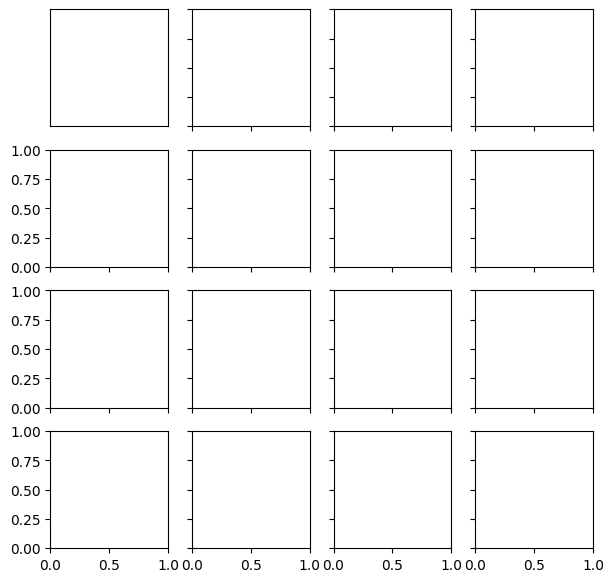

In [24]:
# -1 indicates final epoch's samples (the last in the list)
view_samples(-1, samples)

In [ ]:
@mpc.run_multiprocess(world_size=2)
def draw():
    # Size of the Figure
    plt.figure(figsize=(20, 10))

    # Plot the real images
    plt.subplot(1, 2, 1)
    plt.axis("off")
    plt.title("Real Images")
    real = next(iter(dataloader))
    real = crypten.cryptensor(real[0][:100])
    real = real.get_plain_text()
    plt.imshow(
        # utils.make_grid(real[0][:100] * 0.5 + 0.5, nrow=10).permute(1, 2, 0))
        utils.make_grid(real * 0.5 + 0.5, nrow=10).permute(1, 2, 0))

    # Load the Best Generative Model
    netG = Generator().encrypt()
    netG.load_state_dict(crypten.load('LPGAN.pt', map_location=torch.device('cpu')))
    netG.eval()

    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, nz, 1, 1))
    fixed_z = torch.from_numpy(fixed_z).float()
    fixed_z = crypten.cryptensor(fixed_z)


    # Generate the Fake Images
    with torch.no_grad():
        fake = netG(fixed_z)
        fake = fake.get_plain_text()

    # Plot the fake images
    plt.subplot(1, 2, 2)
    plt.axis("off")
    plt.title("Fake Images")
    fake = utils.make_grid(fake * 0.5 + 0.5, nrow=10)
    plt.imshow(fake.permute(1, 2, 0))

    # Save the comparation result
    plt.savefig('result/result.jpg', bbox_inches='tight')

draw()

====fss====
====fss====


Process Process-6:
Process Process-5:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/sue/anaconda3/envs/sl/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/sue/anaconda3/envs/sl/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/sue/anaconda3/envs/sl/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/sue/anaconda3/envs/sl/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/sue/Project/PR-crypten/CrypTen/crypten/mpc/context.py", line 30, in _launch
    return_value = func(*func_args, **func_kwargs)
  File "/home/sue/Project/PR-crypten/CrypTen/crypten/mpc/context.py", line 30, in _launch
    return_value = func(*func_args, **func_kwargs)
  File "/tmp/ipykernel_69169/1580691762.py", line 30, in draw
    fake = netG(fixed_z)
  F